


# **Support Vector Machine (SVM)**

Maintainer: Zhaohu(Jonathan) Fan. Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.


## Table of Contents
1. [Credit Score Data](#1-credit-score-data)  
   1. [Load Data](#11-load-data)  
2. [Support Vector Machine (SVM)](#2-support-vector-machine-svm)



#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/1d5aEU4P8OTDwMQOZL0nYYG7dPosVHxaL?usp=sharing)*

#### *Useful information about [Support Vector Machine (SVM)in R](https://yanyudm.github.io/Data-Mining-R/lecture/9.C_SVM.html)*



# 1 Credit Score Data

### 1.1 Load Data

In [1]:
# ============================================================
# Load Credit Score data (Python / Google Colab)
# ============================================================
import pandas as pd
from sklearn.model_selection import train_test_split

# 1) Load data
credit_url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/credit0.csv"
credit_data = pd.read_csv(credit_url)

print("Original shape:", credit_data.shape)
credit_data.head()


Original shape: (5000, 63)


,id,Y,X2,X3,X4,X5,X6,X7,X8,X9,...,X22_5,X22_6,X22_7,X22_8,X22_9,X22_10,X22_11,X23_2,X23_3,X24_2
0,413572,0,0.905,-1.188,-0.830,-0.825,-0.537,-0.626,-0.082,-0.211,...,0,0,0,0,0,0,0,0,0,0
1,411680,0,1.239,0.575,1.055,-0.039,-0.537,0.604,-0.228,1.068,...,0,0,0,0,0,0,0,1,0,0
2,408678,0,1.490,1.961,2.402,2.449,0.943,1.130,0.065,-0.140,...,0,0,0,0,0,0,0,0,0,0
3,404876,0,-0.766,-0.936,-0.830,-0.563,-0.537,-0.626,-0.008,-0.211,...,0,0,0,0,0,0,0,0,0,0
4,401738,0,-1.017,-0.685,-0.157,-0.432,0.203,-0.626,-0.155,1.068,...,0,0,0,0,0,0,0,1,0,0


In [2]:
# ============================================================
# Remove X9 and id (not used for prediction)
# ============================================================
credit_data = credit_data.drop(columns=["X9", "id"], errors="ignore")

# Treat Y as a categorical label (as.factor in R)
# (In Python, we typically keep labels as 0/1 integers for modeling.)
credit_data["Y"] = pd.to_numeric(credit_data["Y"])  # will raise if not numeric

print("After dropping columns shape:", credit_data.shape)
print("Y value counts:\n", credit_data["Y"].value_counts())


After dropping columns shape: (5000, 61)
Y value counts:
 Y
0    4700
1     300
Name: count, dtype: int64


In [3]:
# ============================================================
# Split data 90/10 into training/testing sets
# ============================================================
X = credit_data.drop(columns=["Y"])
y = credit_data["Y"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=42,
    shuffle=True,
    stratify=y  # recommended to preserve class balance
)

credit_train = X_train.copy()
credit_train["Y"] = y_train.values

credit_test = X_test.copy()
credit_test["Y"] = y_test.values

print("Training dataset shape:", credit_train.shape)
print("Testing dataset shape: ", credit_test.shape)

print(f"Number of variables (including Y): {credit_train.shape[1]}")
print(f"Number of training observations: {credit_train.shape[0]}")


Training dataset shape: (4500, 61)
Testing dataset shape:  (500, 61)
Number of variables (including Y): 61
Number of training observations: 4500


## 2 Support Vector Machine (SVM)

SVM is one of the best off-the-shelf classifiers for many problems. It handles nonlinearity, is well regularized (helping to avoid overfitting), has relatively few tunable parameters, and can be efficient even with a large number of observations. It can also be adapted for regression tasks (SVR).

In [4]:
# ============================================================
# 2 Support Vector Machine (SVM) — Python / Google Colab
# Replicates the R e1071::svm workflow using scikit-learn (libsvm)
# - Load credit0.csv
# - Drop X9 and id
# - 90/10 train-test split
# - Fit SVM with RBF kernel (cost=1, gamma=1/p)
# - Predict probabilities on test set
# - Classify using cutoff = 0.08
# - Confusion matrix, misclassification rate, and credit_cost
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score


In [5]:
# ------------------------------------------------------------
# 1) Load data and basic cleaning (matches R)
# ------------------------------------------------------------
credit_url = "https://yanyudm.github.io/Data-Mining-R/lecture/data/credit0.csv"
credit_data = pd.read_csv(credit_url)

# Remove X9 and id
credit_data = credit_data.drop(columns=["X9", "id"], errors="ignore")

# Ensure Y is numeric 0/1 (R as.factor)
credit_data["Y"] = pd.to_numeric(credit_data["Y"])

# Split 90/10 (recommended: stratify)
X = credit_data.drop(columns=["Y"])
y = credit_data["Y"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=42,
    shuffle=True,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class counts:", np.bincount(y_train))
print("Test class counts: ", np.bincount(y_test))


Train shape: (4500, 60) Test shape: (500, 60)
Train class counts: [4230  270]
Test class counts:  [470  30]


In [6]:
# ------------------------------------------------------------
# 2) Define credit cost function (same as R)
# ------------------------------------------------------------
def credit_cost(observed, predicted, weight1=10, weight0=1):
    """
    Cost = mean(weight1 * FN + weight0 * FP)
    FN: observed==1 & predicted==0
    FP: observed==0 & predicted==1
    """
    observed = np.asarray(observed).astype(int)
    predicted = np.asarray(predicted).astype(int)

    c1 = (observed == 1) & (predicted == 0)  # false negatives
    c0 = (observed == 0) & (predicted == 1)  # false positives
    return np.mean(weight1 * c1 + weight0 * c0)


In [7]:
# ------------------------------------------------------------
# 3) Fit SVM (RBF kernel) with probability estimates
#    R: cost=1, gamma=1/length(credit.train)
#    In Python:
#      - C corresponds to cost
#      - gamma corresponds to R gamma; we set gamma = 1/p
#      - Use StandardScaler (SVM is very scale-sensitive)
# ------------------------------------------------------------
p = X_train.shape[1]
gamma_value = 1 / p   # analogous to R code

svm_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svc", SVC(
        kernel="rbf",
        C=1.0,                 # cost = 1
        gamma=gamma_value,     # gamma = 1/p
        probability=True,      # needed for predict_proba
        random_state=42
    ))
])

svm_model.fit(X_train, y_train)
print(f"Fitted SVM with C=1.0, gamma={gamma_value:.6f}, p={p}")


Fitted SVM with C=1.0, gamma=0.016667, p=60


In [8]:
# ------------------------------------------------------------
# 4) Predict probabilities on test set and classify with cutoff
#    R: pred.svm = as.numeric(prob >= 0.08)
# ------------------------------------------------------------
cutoff = 0.08

prob_svm = svm_model.predict_proba(X_test)[:, 1]   # P(Y=1)
pred_svm = (prob_svm >= cutoff).astype(int)

# Confusion matrix (like R table)
cm = confusion_matrix(y_test, pred_svm, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=["Obs 0", "Obs 1"], columns=["Pred 0", "Pred 1"])
cm_df


,Pred 0,Pred 1
Obs 0,412,58
Obs 1,22,8


In [9]:
# ------------------------------------------------------------
# 5) Misclassification rate + credit cost (matches R outputs)
# ------------------------------------------------------------
mis_rate = np.mean(y_test.values != pred_svm)
cost_val = credit_cost(y_test.values, pred_svm)

print(f"Cutoff: {cutoff:.2f}")
print(f"Misclassification rate: {mis_rate:.4f}")
print(f"Accuracy: {accuracy_score(y_test, pred_svm):.4f}")
print(f"Credit cost: {cost_val:.4f}")


Cutoff: 0.08
Misclassification rate: 0.1600
Accuracy: 0.8400
Credit cost: 0.5560


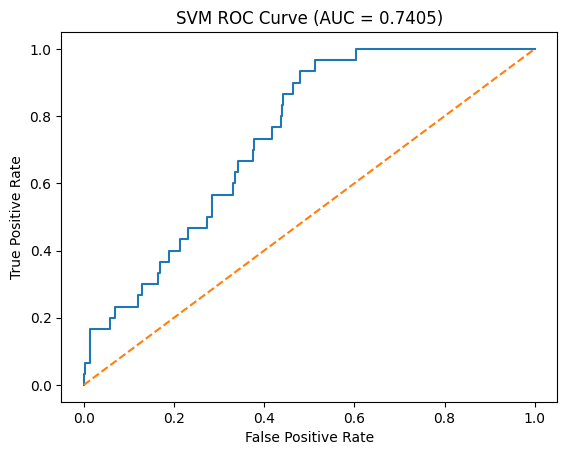

ROC AUC: 0.7405


In [14]:
# Optional: ROC AUC (since we have probabilities)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

auc = roc_auc_score(y_test, prob_svm)
fpr, tpr, _ = roc_curve(y_test, prob_svm)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"SVM ROC Curve (AUC = {auc:.4f})")
plt.show()

print(f"ROC AUC: {auc:.4f}")


In [15]:
%%shell
jupyter nbconvert --to html ///content/9_C_Support_vector_machine.ipynb

[NbConvertApp] Converting notebook ///content/9_C_Support_vector_machine.ipynb to html
[NbConvertApp] Writing 318424 bytes to /content/9_C_Support_vector_machine.html
